#  **Install and Load Packages**

In [29]:
# This SMOTE package was installed from github
# The function can also be used to obtain directely the classification model from the resulting balanced dataset
remotes::install_github("cran/DMwR", quiet=TRUE)

In [30]:
# side by side pairs plots packages
install.packages("ggcorrplot", quiet=TRUE)
install.packages("cowplot", quiet = TRUE)

In [31]:
# Load packages
library(xgboost)
library(caret)
library(ggcorrplot)
library(cowplot)
library(pROC)
library(DMwR)

# **Data Import**

In [32]:
# Set a random seed for reproducibility
set.seed(123)
# Load data from bank campaign survey collection
data <- read.csv("train.csv", stringsAsFactors = TRUE)
# Split data into training and testing sets
train_index <- createDataPartition(data$outcome, p = 0.75, list = FALSE)
train_data <- data[train_index, ]
test_data <- data[-train_index, ]
str(train_data)

'data.frame':	21624 obs. of  21 variables:
 $ id        : int  104222 126970 123366 100832 130133 111601 119834 132218 118433 109276 ...
 $ age       : int  27 57 42 49 42 31 56 28 47 37 ...
 $ job       : Factor w/ 12 levels "admin.","artisan",..: 8 8 3 10 1 1 2 9 10 2 ...
 $ civil     : Factor w/ 4 levels "divorced","married",..: 3 1 2 2 2 1 2 3 1 2 ...
 $ edu       : Factor w/ 8 levels "12K","4K","6K",..: 4 8 7 5 1 7 2 1 7 4 ...
 $ credit    : Factor w/ 3 levels "no","unknown",..: 1 1 1 1 1 1 2 2 1 1 ...
 $ hloan     : Factor w/ 3 levels "no","unknown",..: 1 1 1 1 3 3 1 3 1 3 ...
 $ ploan     : Factor w/ 3 levels "no","unknown",..: 1 1 1 3 1 1 1 1 1 1 ...
 $ ctype     : Factor w/ 2 levels "cellular","telephone": 2 1 2 2 2 1 2 2 1 2 ...
 $ month     : Factor w/ 10 levels "apr","aug","dec",..: 7 7 7 5 7 2 7 5 7 7 ...
 $ day       : Factor w/ 5 levels "fri","mon","thu",..: 2 1 2 3 4 2 2 2 1 3 ...
 $ ccontact  : int  2 4 1 1 1 2 1 2 3 4 ...
 $ lcdays    : int  999 999 999 999 999 999 99

# **Data Exploration**

In [33]:
# Check if there are any null values
sum(any(is.na(train_data)))
# summary statistic 
summary(train_data)

[1] 0

       id              age                job            civil      
 Min.   :100001   Min.   :17.00   admin.    :5365   divorced: 2384  
 1st Qu.:110395   1st Qu.:32.00   artisan   :4875   married :13115  
 Median :120580   Median :38.00   technician:3536   single  : 6082  
 Mean   :120604   Mean   :40.14   services  :2097   unknown :   43  
 3rd Qu.:130840   3rd Qu.:47.00   management:1522                   
 Max.   :141188   Max.   :98.00   retired   : 935                   
                                  (Other)   :3294                   
             edu           credit          hloan           ploan      
 university    :6292   no     :17038   no     : 9821   no     :17811  
 12K           :5004   unknown: 4583   unknown:  503   unknown:  503  
 9K            :3176   yes    :    3   yes    :11300   yes    : 3310  
 apprenticeship:2763                                                  
 4K            :2270                                                  
 6K            :1190  

In [34]:
#Checking response variables class imbalanced
prop.table(table(train_data$outcome))


        0         1 
0.8872549 0.1127451 

In [35]:
# Descriptive statistics for Numerical variables
summary(train_data[c("age", "employment", "cprice", "cconf", "euri3", "employees", "outcome")])

      age          employment           cprice          cconf       
 Min.   :17.00   Min.   :-3.40000   Min.   :92.20   Min.   :-50.80  
 1st Qu.:32.00   1st Qu.:-1.80000   1st Qu.:93.08   1st Qu.:-42.70  
 Median :38.00   Median : 1.10000   Median :93.75   Median :-41.80  
 Mean   :40.14   Mean   : 0.06876   Mean   :93.57   Mean   :-40.51  
 3rd Qu.:47.00   3rd Qu.: 1.40000   3rd Qu.:93.99   3rd Qu.:-36.40  
 Max.   :98.00   Max.   : 1.40000   Max.   :94.77   Max.   :-26.90  
     euri3         employees       outcome      
 Min.   :0.634   Min.   :4964   Min.   :0.0000  
 1st Qu.:1.344   1st Qu.:5099   1st Qu.:0.0000  
 Median :4.857   Median :5191   Median :0.0000  
 Mean   :3.610   Mean   :5167   Mean   :0.1127  
 3rd Qu.:4.961   3rd Qu.:5228   3rd Qu.:0.0000  
 Max.   :5.045   Max.   :5228   Max.   :1.0000  

**4x4 grid of bar charts for numerical variable**

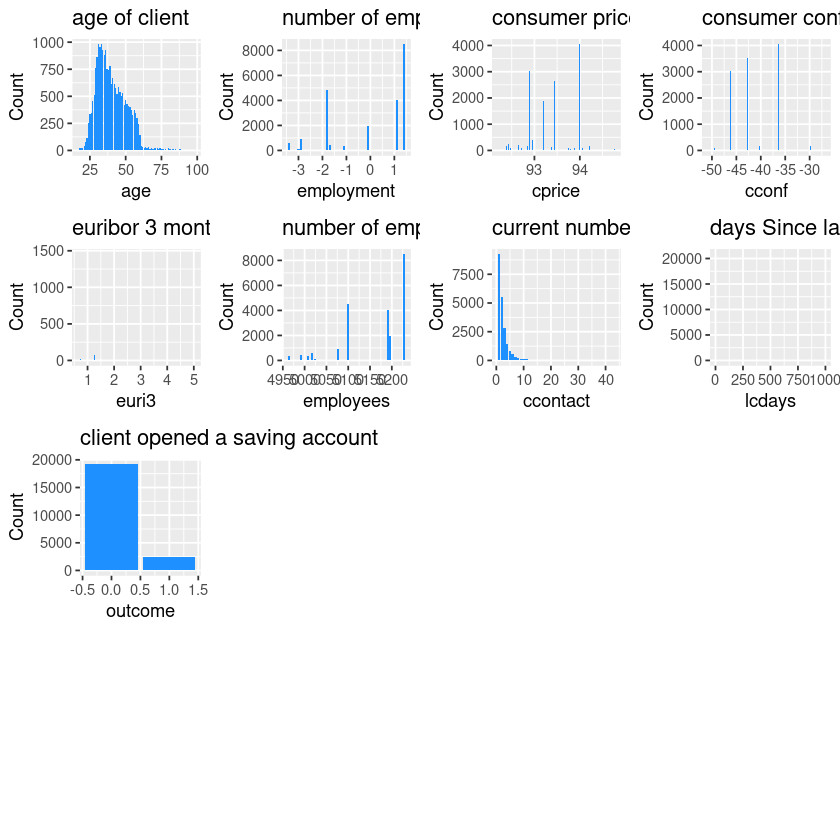

In [36]:
# Create a 4x4 grid of bar charts for numerical variable
plot_grid(
  # Bar chart for age
  ggplot(train_data, aes(x=age)) +
    geom_bar( fill="dodgerblue") +
    labs(x="age", y="Count") +
    ggtitle("age of client"),
  
  # Bar chart for employment
  ggplot(train_data, aes(x=employment)) +
    geom_bar(fill="dodgerblue") +
    labs(x="employment", y="Count") +
    ggtitle("number of employees"),
  
  # Bar chart for cprice
  ggplot(train_data, aes(x=cprice)) +
    geom_bar(fill="dodgerblue") +
    labs(x="cprice", y="Count") +
    ggtitle("consumer price index"),
  
  # Bar chart for cconf
  ggplot(train_data, aes(x=cconf)) +
    geom_bar(fill="dodgerblue") +
    labs(x="cconf", y="Count") +
    ggtitle("consumer confidence Index"),
  
  # Bar chart for euri3
  ggplot(train_data, aes(x=euri3)) +
    geom_bar(fill="dodgerblue") +
    labs(x="euri3", y="Count") +
    ggtitle("euribor 3 month rate "),
  
  # Bar chart for employees
  ggplot(train_data, aes(x=employees)) +
    geom_bar(fill="dodgerblue") +
    labs(x="employees", y="Count") +
    ggtitle("number of employees"),
  
  # Bar chart for ccontact
  ggplot(train_data, aes(x=ccontact)) +
    geom_bar(fill="dodgerblue") +
    labs(x="ccontact", y="Count") +
    ggtitle("current number of contacts"),
  
  # Bar chart for lcdays
  ggplot(train_data, aes(x=lcdays)) +
    geom_bar(fill="dodgerblue") +
    labs(x="lcdays", y="Count") +
    ggtitle("days Since last contact"),
  
  # Bar chart for outcome (Target variable)
  ggplot(train_data, aes(x=outcome)) +
    geom_bar(fill="dodgerblue") +
    labs(x="outcome", y="Count") +
    ggtitle("client opened a saving account"),
  
  nrow=4, ncol=4)


**4x4 grid of bar charts for categorical variable**

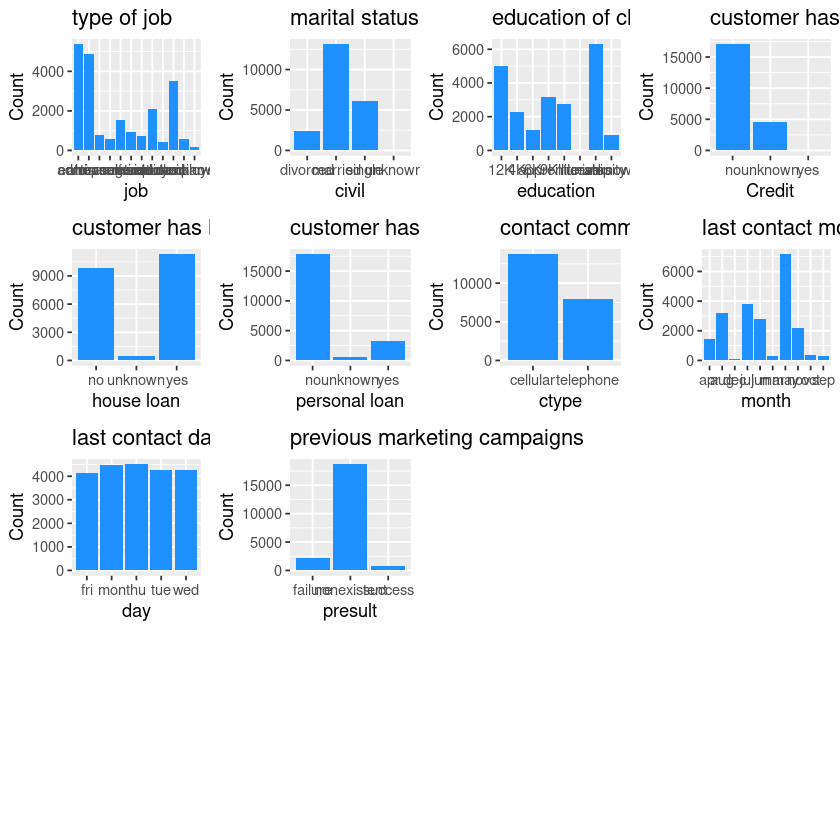

In [37]:

# Create a 4x4 grid of bar charts for categorical variable
plot_grid(
  # Bar chart for job
  ggplot(train_data, aes(x=job)) +
    geom_bar( fill="dodgerblue") +
    labs(x="job", y="Count") +
    ggtitle("type of job"),
  
  # Bar chart for civil
  ggplot(train_data, aes(x=civil)) +
    geom_bar(fill="dodgerblue") +
    labs(x="civil", y="Count") +
    ggtitle("marital status of client"),
  
  # Bar chart for edu
  ggplot(train_data, aes(x=edu)) +
    geom_bar(fill="dodgerblue") +
    labs(x="education", y="Count") +
    ggtitle("education of client"),
  
  # Bar chart for credit
  ggplot(train_data, aes(x=credit)) +
    geom_bar(fill="dodgerblue") +
    labs(x="Credit", y="Count") +
    ggtitle("customer has credit in default?"),
  
  # Bar chart for hloan
  ggplot(train_data, aes(x=hloan)) +
    geom_bar(fill="dodgerblue") +
    labs(x="house loan", y="Count") +
    ggtitle("customer has housing loan?"),
  
  # Bar chart for ploan
  ggplot(train_data, aes(x=ploan)) +
    geom_bar(fill="dodgerblue") +
    labs(x="personal loan", y="Count") +
    ggtitle("customer has personal loan?"),
  
  # Bar chart for ctype
  ggplot(train_data, aes(x=ctype)) +
    geom_bar(fill="dodgerblue") +
    labs(x="ctype", y="Count") +
    ggtitle("contact communication type"),
  
  # Bar chart for month
  ggplot(train_data, aes(x=month)) +
    geom_bar(fill="dodgerblue") +
    labs(x="month", y="Count") +
    ggtitle("last contact month of year"),
  
  # Bar chart for day
  ggplot(train_data, aes(x=day)) +
    geom_bar(fill="dodgerblue") +
    labs(x="day", y="Count") +
    ggtitle("last contact day of the week"),
  
  # Bar chart for presult
  ggplot(train_data, aes(x=presult)) +
    geom_bar(fill="dodgerblue") +
    labs(x="presult", y="Count") +
    ggtitle("previous marketing campaigns"),
  
  nrow=4, ncol=4)

In [38]:
# Get the proportion/percentage of client opened a saving accounts
pcs_opened <- prop.table(table(train_data$outcome)) * 100
cat(paste('percentage of not opened account',round(pcs_opened[1],0)),"%" )
cat(paste('percentage of opened account',round(pcs_opened[2],0)),"%" ) # Imbalanced in class 1 Target variables


percentage of not opened account 89 %percentage of opened account 11 %

In [39]:
# Correlation matrix for numerical variables
corr_matrix <- cor(train_data[,c("age", "employment", "cprice", "cconf", "euri3", "employees", "ccontact", 'lcdays', "pcontact", "outcome")])
#print(corr_matrix)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


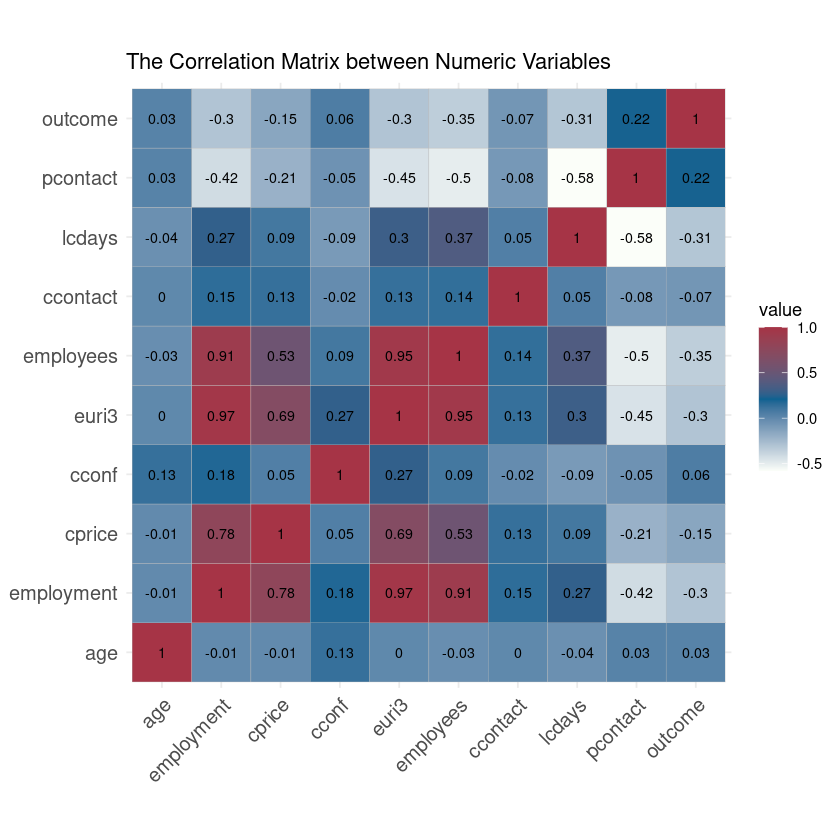

In [40]:
# Define custom color scale
my_colors <- c("#FBFEF9", "#0C6291", "#A63446")
color_scale <- scale_fill_gradientn(colors = my_colors)
ggcorrplot(corr_matrix, type = "full", lab = TRUE, lab_size = 3) + 
  color_scale  + 
  ggtitle("The Correlation Matrix between Numeric Variables")

In [41]:
head(train_data)

,id,age,job,civil,edu,credit,hloan,ploan,ctype,month,⋯,ccontact,lcdays,pcontact,presult,employment,cprice,cconf,euri3,employees,outcome
,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2,104222,27,services,single,9K,no,no,no,telephone,may,⋯,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,126970,57,services,divorced,unknown,no,no,no,cellular,may,⋯,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
4,123366,42,entrepreneur,married,university,no,no,no,telephone,may,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,0
5,100832,49,technician,married,apprenticeship,no,no,yes,telephone,jun,⋯,1,999,0,nonexistent,1.4,94.465,-41.8,4.958,5228.1,0
7,130133,42,admin.,married,12K,no,yes,no,telephone,may,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
9,111601,31,admin.,divorced,university,no,yes,no,cellular,aug,⋯,2,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0


# **Data Preprocessing**

In [42]:
# Remove id variable from datasets
train_data <- train_data[, -which(names(train_data) == "id")]
test_data <- test_data[, -which(names(test_data) == "id")]

In [43]:
# Balance training data using SMOTE
train_data$outcome <- as.factor(train_data$outcome)
train_data_balanced <- SMOTE(outcome ~ ., data = train_data,  perc.over = 200, k = 5)

In [44]:
# Convert outcome variable to a binary factor with levels 0 and 1
train_data_balanced$outcome <- factor(train_data_balanced$outcome, levels = c(0, 1))
test_data$outcome <- factor(test_data$outcome, levels = c(0, 1))

In [45]:
# Encode categorical variables using one-hot encoding
train_features <- model.matrix(~.-1, data = train_data_balanced[, -which(names(train_data_balanced) == "outcome")])
test_features <- model.matrix(~.-1, data = test_data[, -which(names(test_data) == "outcome")])

# **Model fitting**

In [46]:
# Convert data to DMatrix format
dtrain <- xgb.DMatrix(data = train_features, label = as.numeric(train_data_balanced$outcome) - 1)
dtest <- xgb.DMatrix(data = test_features, label = as.numeric(test_data$outcome) - 1)

# Set XGBoost parameters
params <- list(
  objective = "binary:logistic",
  eval_metric = "auc",
  eta = 0.1,
  max_depth = 8,
  subsample = 0.8,
  colsample_bytree = 0.8
  
)
set.seed(123)
# Train XGBoost model
xgb_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 40,
  watchlist = list(train = dtrain, test = dtest),
  early_stopping_rounds = 10,
  verbose = 0
  
)

In [47]:
print(xgb_model) 

##### xgb.Booster
raw: 283.5 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = 40, watchlist = list(train = dtrain, 
    test = dtest), verbose = 0, early_stopping_rounds = 10)
params (as set within xgb.train):
  objective = "binary:logistic", eval_metric = "auc", eta = "0.1", max_depth = "8", subsample = "0.8", colsample_bytree = "0.8", validate_parameters = "TRUE"
xgb.attributes:
  best_iteration, best_msg, best_ntreelimit, best_score, niter
callbacks:
  cb.evaluation.log()
  cb.early.stop(stopping_rounds = early_stopping_rounds, maximize = maximize, 
    verbose = verbose)
# of features: 53 
niter: 40
best_iteration : 38 
best_ntreelimit : 38 
best_score : 0.8012967 
best_msg : [38]	train-auc:0.956207	test-auc:0.801297 
nfeatures : 53 
evaluation_log:
    iter train_auc  test_auc
       1 0.9228397 0.7809562
       2 0.9280644 0.7860988
---                         
      39 0.9573601 0.7997967
      40 0.9578257 0.7992345


# **Top 10 Features Importance for model**

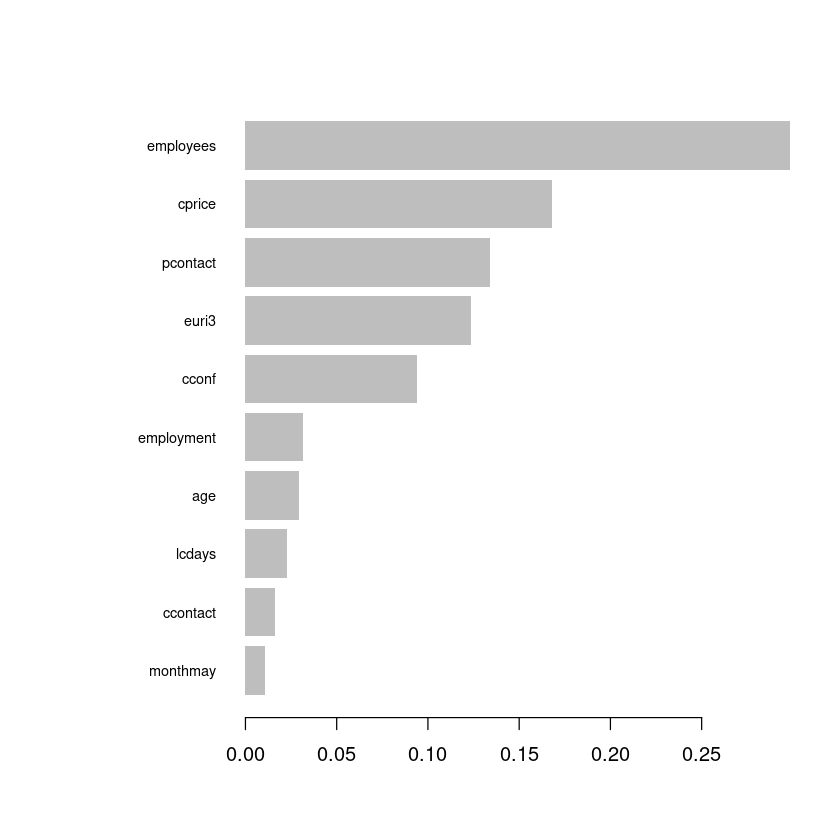

In [48]:
# Get feature importances
importance <- xgb.importance(feature_names = colnames(train_features), model = xgb_model)
xgb.plot.importance(importance_matrix = importance, top_n = 10)

# **Model Validation**

Accuracy: 0.8923269 
AUC: 0.8012967 


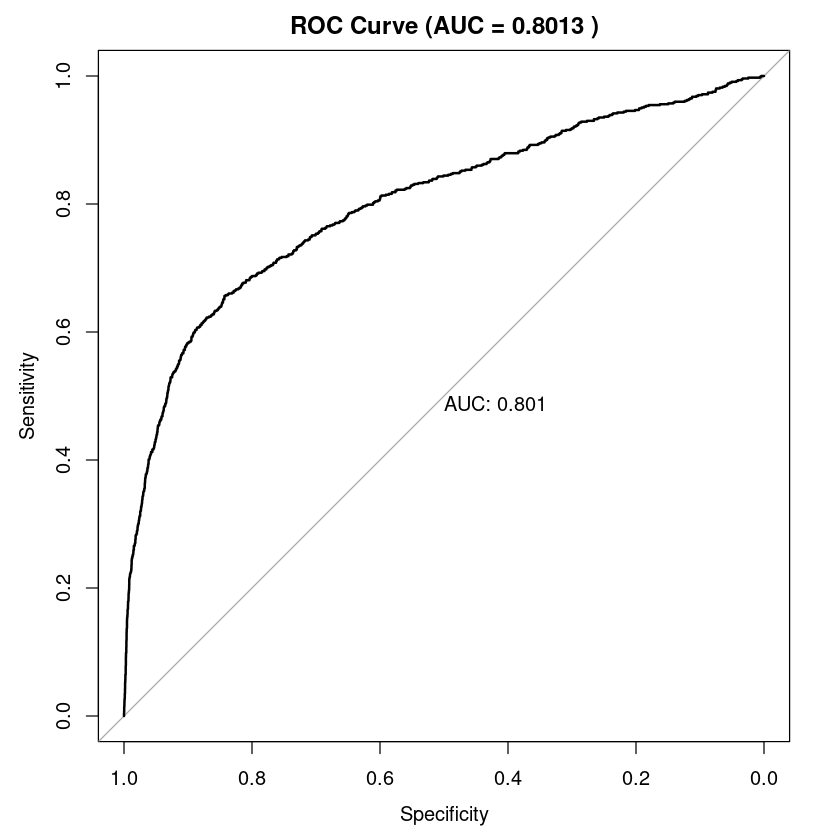

In [49]:
# Make predictions on test data
pred <- predict(xgb_model, dtest)
# Evaluate model performance
conf_mat <- table(test_data$outcome, pred >= 0.5)
accuracy <- sum(diag(conf_mat)) / sum(conf_mat)
auc <- roc(test_data$outcome, pred, quiet = TRUE)$auc
cat("Accuracy:", accuracy, "\n")
cat("AUC:", auc, "\n")
# Create ROC curve
roc_data <- roc(test_data$outcome, pred, quiet = TRUE)
# Plot ROC curve and AUC
plot(roc_data, main = paste("ROC Curve (AUC =", round(auc, 4), ")"), print.auc = TRUE)

# **Model Evaluation** 

In [114]:
# Load new test data
new_test_data <- read.csv("test.csv", stringsAsFactors = TRUE)
new_test_data_custId = new_test_data$id
# Preprocess new test data
all_levels <- unique(c(levels(train_data$credit), levels(new_test_data$credit)))
new_test_data$credit <- factor(new_test_data$credit, levels = all_levels)
new_test_data <- new_test_data[, -which(names(new_test_data) == "id")]
new_test_features <- model.matrix(~.-1, data = new_test_data)
# Set the feature names of the new test data to be the same as the feature names in the training data
colnames(new_test_features) <- colnames(train_features)
# Use trained XGBoost model to make predictions on new test data
pred_new <- predict(xgb_model, new_test_features)

# **Predicted results for customer who open an savings account from marketing campaign**

In [115]:
submission <- cbind(new_test_data_custId, pred_new)
colnames(submission) <- c("customer id", "outcome")
head(submission)
#write.csv(submission, file = "submission.csv", row.names = FALSE)

customer id,outcome
103174,0.07056557
134356,0.06457689
127090,0.06457689
132548,0.07607714
137587,0.05652229
115477,0.07204072


In [144]:
is_account_opened <- ifelse(pred_new >= 0.5, "1", "0")
total_open_account <- sum(is_account_opened == "1")
total_customers <- nrow(new_test_data)
percentage_opened <- total_open_account / total_customers * 100

cat("The percentage of customers who opened a savings account in bank's marketing campaign: ", paste(round(percentage_opened, 0), "%"), "\n")

The percentage of customers who opened a savings account in bank's marketing campaign:  11 % 


# **Business Implication**

Based on the analysis and the results obtained from the prediction model, the following business implications can be derived to enhance the effectiveness of future marketing campaigns for promoting savings accounts. The following recommendation are

Prioritize employee training and motivation in promoting savings accounts, ensuring that incentives and performance measurement systems align with the organization's goals for account openings.
Previous contact optimization: Leverage the client's interaction history, including the number of contacts made in the current campaign (ccontact) and previous campaigns (pcontact), as well as the last contact days (lcdays), to develop optimized follow-up strategies that keep customers engaged and interested in the savings products
Economic indicators: The analysis identified a correlation between customer confidence in the economy and their likelihood of opening a savings account. Monitoring economic indicators and adjusting marketing strategies accordingly could help the bank capitalize on periods of high customer confidence to promote its savings products more effectively.
Targeting specific customer segments: Utilize demographic and socioeconomic factors such as age, job type, and civil status to tailor marketing efforts towards specific customer segments, resulting in higher success rates for account openings
Addressing data imbalance: The imbalance in the dependent variable "outcome" is an important factor to consider when evaluating the predictive models. Future marketing efforts should aim to collect more data on successful account openings to improve the accuracy and effectiveness of predictive models.

In conclusion, the bank can enhance its marketing campaigns for savings accounts by optimizing pricing strategies, employee engagement, targeting specific customer segments, monitoring economic indicators, various communication channels, and addressing data imbalances. These insights, along with the predictive capabilities of the prediction model, can contribute to more effective and efficient marketing strategies, ultimately leading to a higher rate of account openings.

